# Code

In [15]:
"""from google.colab import drive
drive.mount('/content/gdrive')
"""


"from google.colab import drive\ndrive.mount('/content/gdrive')\n"

mur des import

In [16]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import choice
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Model, Sequential
from keras import layers
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation,GlobalMaxPooling2D
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split as tts


## Partie 1 : Base de données, Analyse et Préparation

In [17]:
#dataset_path = '/content/gdrive/My Drive/Colab Notebooks/ressource/Mask_Data-20230914T090722Z-001/Mask_Data'
dataset_path = './its_scraping_time/'



#### creation de 2 classe de sortie su model


In [18]:
class_name = choice(['non_casque', 'oui_casque'])
class_path = os.path.join(dataset_path, class_name)

### afichage d'une image prise de facon aleatoire

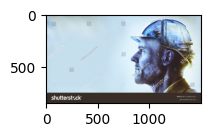

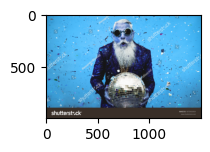

In [19]:
image_name = choice(os.listdir(class_path))
image_path1 = os.path.join('its_scraping_time/oui_casque/', image_name)
image_path2 = os.path.join('its_scraping_time/non_casque/', image_name)

# Read and Display the random image
image1 = cv2.imread(image_path1)
image2 = cv2.imread(image_path2)
plt.figure(figsize=(2, 2))
plt.imshow(image1)
plt.show()
plt.figure(figsize=(2, 2))
plt.imshow(image2)
plt.show()

### prepatation des data pour l'entrainement et la validation

In [20]:
"""# biblioteque d'aplicatif pour les données  d'entraînement
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

# biblioteque d'aplicatif pour les données de validation
val_datagen = ImageDataGenerator(rescale=1./255)

# Define the batch size
batch_size = 32

# générateurs de données d'entraînement et de validation suplementaire
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['non_casque', 'oui_casque'])

val_generator = val_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    classes=['non_casque', 'oui_casque'],
    shuffle=False)
"""
img_height, img_width = 224, 224
batch_size = 32

#Data_Augmentation
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.20
)

train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    subset='validation'
)

Found 1532 images belonging to 2 classes.
Found 383 images belonging to 2 classes.


In [21]:
print(len(train_generator))
print(len(val_generator))

48
12


## Partie2 : Architecture CNN sur Keras

### importaion du model (VGG16) pré-entrainé

In [22]:
from keras.applications.vgg16 import VGG16
vgg16 = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

### entrainement "oui non"
donné la posibilté ou non,  de ré'entrainé le reseau de nerone du model "vgg16"

si "non" l'entrenement se passera uniquement sur les couche du reseau de neurone que l'on va ajouté


    True = entrainement sur tout le reseau de nerone (peu demandé baucoup plus de resource)
    False = le reseau de nerone est gelé et uniquement les couches ajouté seront entrainé

In [23]:
for layer in vgg16.layers:
    layer.trainable = False
    #layer.trainable = True

### ajout de couche neuronal au model

Dense pour ajouter 2 couche de nerone au modèle

model qui doit etre unidimensionnel pour utilisé "Dense"


utilisation de flatten pour aplatir la sortie du modèle et donc le rendre unidimensionelle.

(la dernierre couche ajoute 1 neurone car on a 2 classe et donc une sortie booleene True,False est possible)

In [24]:
from keras.layers import Dense, Flatten
from keras.models import Model


# Add a new fully connected layer
x = Flatten()(vgg16.output)
x = Dense(256, activation='relu')(x)
x = Dense(1, activation='sigmoid')(x)

# Create a new model
model = Model(inputs=vgg16.input, outputs=x)

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

Total params: 21137729 (80.63 MB)
Trainable params: 6423041 (24.50 MB)
Non-trainable params: 14714688 (56.13 MB)
_________________________________________________________________


In [25]:
#filepath = '/content/gdrive/My Drive/Colab Notebooks/ressource/best_model.h5'
filepath = './best_model.h5'
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', save_best_only=True, mode='max', verbose=1)


In [26]:
print(len(train_generator))
print(len(val_generator))

48
12


### entrainement du model

In [27]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [29]:
# Train the model
# Train the model
history = model.fit(
    train_generator,
    #steps_per_epoch=len(train_generator) // batch_size,
    validation_data=val_generator,
    #validation_steps=len(val_generator) // batch_size,
    epochs=20,
    callbacks=[checkpoint] #save du meilleur model
)

# 4minutes in T4googleColab
# loss: 0.0056 - accuracy: 0.9993 - val_loss: 0.0046 - val_accuracy: 0.9993

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 0.6636 - accuracy: 0.6514
Epoch 1: accuracy improved from -inf to 0.65144, saving model to ./best_model.h5
48/48 [==============================] - 210s 4s/step - loss: 0.6636 - accuracy: 0.6514 - val_loss: 0.4967 - val_accuracy: 0.8172
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.4400 - accuracy: 0.8166
Epoch 2: accuracy improved from 0.65144 to 0.81658, saving model to ./best_model.h5
48/48 [==============================] - 179s 4s/step - loss: 0.4400 - accuracy: 0.8166 - val_loss: 0.4551 - val_accuracy: 0.7728
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.3390 - accuracy: 0.8584
Epoch 3: accuracy improved from 0.81658 to 0.85836, saving model to ./best_model.h5
48/48 [==============================] - 181s 4s/step - loss: 0.3390 - accuracy: 0.8584 - val_loss: 0.3619 - val_accuracy: 0.8460
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 0.2591 - ac

### Suivi des epochs


affiche grafiquement l'evolution de l'accuracy et de la perte du modèle au fil des epochs



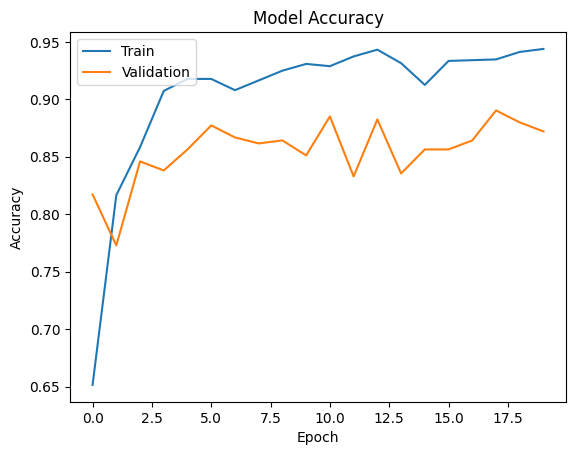

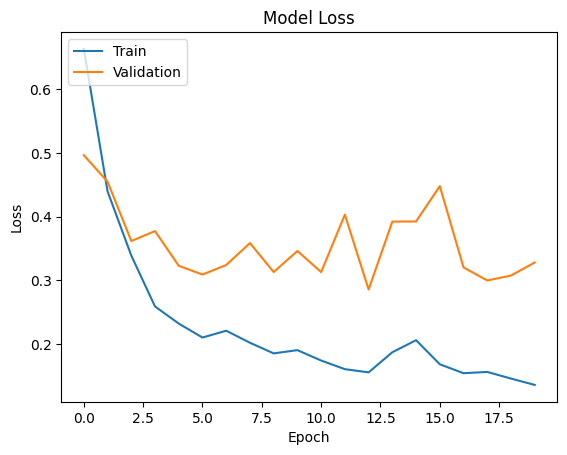

In [30]:
# Plot the training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

print()

# Plot the training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [31]:
def preprocess_image_to_test(image_path):
    # Load the image
    image = cv2.imread(image_path)

    # Resize the image while maintaining its aspect ratio
    h, w, _ = image.shape
    if h > w:
        ratio = 224 / h
    else:
        ratio = 224 / w
    resized_img = cv2.resize(image, (int(w * ratio), int(h * ratio)), interpolation=cv2.INTER_AREA)

    # Add padding to make the image 224x224
    h, w, _ = resized_img.shape
    pad_h = (224 - h) // 2
    pad_w = (224 - w) // 2
    padded_img = cv2.copyMakeBorder(resized_img, pad_h, pad_h, pad_w, pad_w, cv2.BORDER_CONSTANT)

    # Preprocess the image
    image = np.expand_dims(padded_img, axis=0)
    image = image / 255.0

    # Resize the image to (224, 224, 3)
    image = cv2.resize(image[0], (224, 224), interpolation=cv2.INTER_AREA)
    image = np.expand_dims(image, axis=0)

    return image

## Partie 3 : Application

In [32]:
from tensorflow.keras.models import load_model

#model = load_model('/content/gdrive/My Drive/Colab Notebooks/ressource/best_model.h5')
model = load_model('best_model.h5')


### lot d'image de test pour la prediction du model

In [33]:
test_path = './test/'
#test_path = '/content/gdrive/My Drive/Colab Notebooks/ressource/Mask_Data-20230914T090722Z-001/test'

# Load some images to test
test01 = preprocess_image_to_test(f'{test_path }/2023-09-14-124411.jpg')
test02 = preprocess_image_to_test(f'{test_path }/2023-09-14-124412.jpg')
test03 = preprocess_image_to_test(f'{test_path }/2023-09-15-114932.jpg')
test04 = preprocess_image_to_test(f'{test_path }/2023-09-15-115050.jpg')


normalisaion des image de test

In [34]:
test02.shape


(1, 224, 224, 3)

exemple de shape attendu

    (1, 224, 224, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


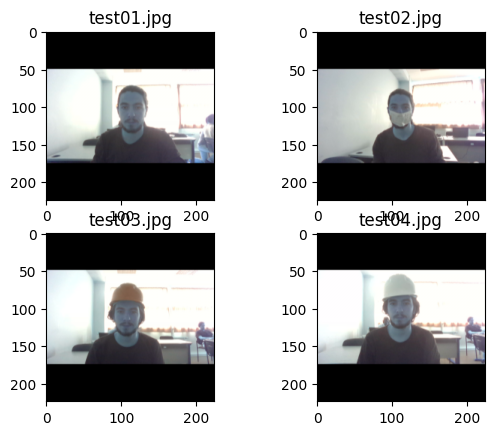

In [35]:
# Display the test images
plt.subplot(2, 2, 1)
plt.imshow(test01[0])
plt.title('test01.jpg')

plt.subplot(2, 2, 2)
plt.imshow(test02[0])
plt.title('test02.jpg')

plt.subplot(2, 2, 3)
plt.imshow(test03[0])
plt.title('test03.jpg')

plt.subplot(2, 2, 4)
plt.imshow(test04[0])
plt.title('test04.jpg')


plt.show()

### Prediction

In [36]:
# Make predictions
prediction01 = model.predict(test01)
prediction02 = model.predict(test02)
prediction03 = model.predict(test03)
prediction04 = model.predict(test04)
print()

# Print the predictions
if prediction01 < 0.5:
    print('The person in test01.jpg is not wearing a casque.')
else:
    print('The person in test01.jpg is wearing a casque.')

if prediction02 < 0.5:
    print('The person in test02.jpg is not wearing a casque.')
else:
    print('The person in test02.jpg is wearing a casque.')
if prediction03 < 0.5:
    print('The person in test03.jpg is not wearing a casque.')
else:
    print('The person in test03.jpg is wearing a casque.')
if prediction04 < 0.5:
    print('The person in test04.jpg is not wearing a casque.')
else:
    print('The person in test04.jpg is wearing a casque.')


1/1 [==============================] - 0s 117ms/step

The person in test01.jpg is not wearing a casque.
The person in test02.jpg is not wearing a casque.
The person in test03.jpg is not wearing a casque.
The person in test04.jpg is not wearing a casque.
